# 1. Problem Context: 
## 1.1 Problem which exists:
Currently, the retailer simply groups their international customers by country. As you'll see in the project, this is quite inefficient because:
* There's a large number of countries (which kind of defeats the purpose of creating groups).
* Some countries have very few customers.
* This approach treats large and small customers the same, regardless of their purchase patterns.

## 1.2 Solution to come up with:
The retailer needs help to create customer clusters, a.k.a **"customer segments"** through a data-driven approach.
* They've provided us a dataset of past purchase data at the transaction level.
* Our task is to build a clustering model using that dataset.
* Our clustering model should factor in both aggregate sales patterns and specific items purchased.


# 2. Technical Specifications and Aspects:
## 2.1 Data Overview
For this project:
* The dataset has 35116 observations for previous international transactions.
* The observations span 37 different countries.
* **Note:** There is no target variable.

We have the following features:

Invoice information
* 'InvoiceNo' – Unique ID for invoice
* 'InvoiceDate' – Invoice date

Item information
* 'StockCode' – Unique ID for item
* 'Description' – Text description for item
* 'Quantity' – Units per pack for item
* 'UnitPrice' – Price per unit in GBP

Customer information
* 'CustomerID' – Unique ID for customer
* 'Country' – Country of customer

## Type of ML Problem
It is an unsupervised learning task, where given the features about each transaction, we need to segment the customers based on their buying patterns.
* It is important to note that the given data is transaction-level while the clusters (or segmenst) we need to create are customer-level.


# 3. Exploratory Data Analysis

Importing the required libraries and their giving a description to why it is used

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Visualizing missing data more effectively
import missingno as msno

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

## 3.1 Loading the dataset

In [2]:
df = pd.read_csv('C:/Users/satvi/OneDrive/Desktop/Customer_segmentation_project2/int_online_tx.csv')

Load international online transactions data from CSV

In [3]:
df.shape

(35116, 8)

In [4]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12-01-2022 08:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12-01-2022 08:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12-01-2022 08:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12-01-2022 08:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12-01-2022 08:45,0.65,12583.0,France
5,536370,22002,INFLATABLE POLITICAL GLOBE,48,12-01-2022 08:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12-01-2022 08:45,1.25,12583.0,France
7,536370,22235,SET/2 RED RETROSPOT TEA TOWELS,18,12-01-2022 08:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12-01-2022 08:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12-01-2022 08:45,1.95,12583.0,France


printing the dimension of and the first 10 rows of the dataset

In [5]:
df.info

<bound method DataFrame.info of        InvoiceNo StockCode                      Description  Quantity  \
0         536370     22728        ALARM CLOCK BAKELIKE PINK        24   
1         536370     22727        ALARM CLOCK BAKELIKE RED         24   
2         536370     22726       ALARM CLOCK BAKELIKE GREEN        12   
3         536370     21724  PANDA AND BUNNIES STICKER SHEET        12   
4         536370     21883                 STARS GIFT TAPE         24   
...          ...       ...                              ...       ...   
35111     581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
35112     581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
35113     581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
35114     581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
35115     581587     22138    BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID Country  
0      12-01-2022 08:45       3.75

## 3.3 Handle missing values

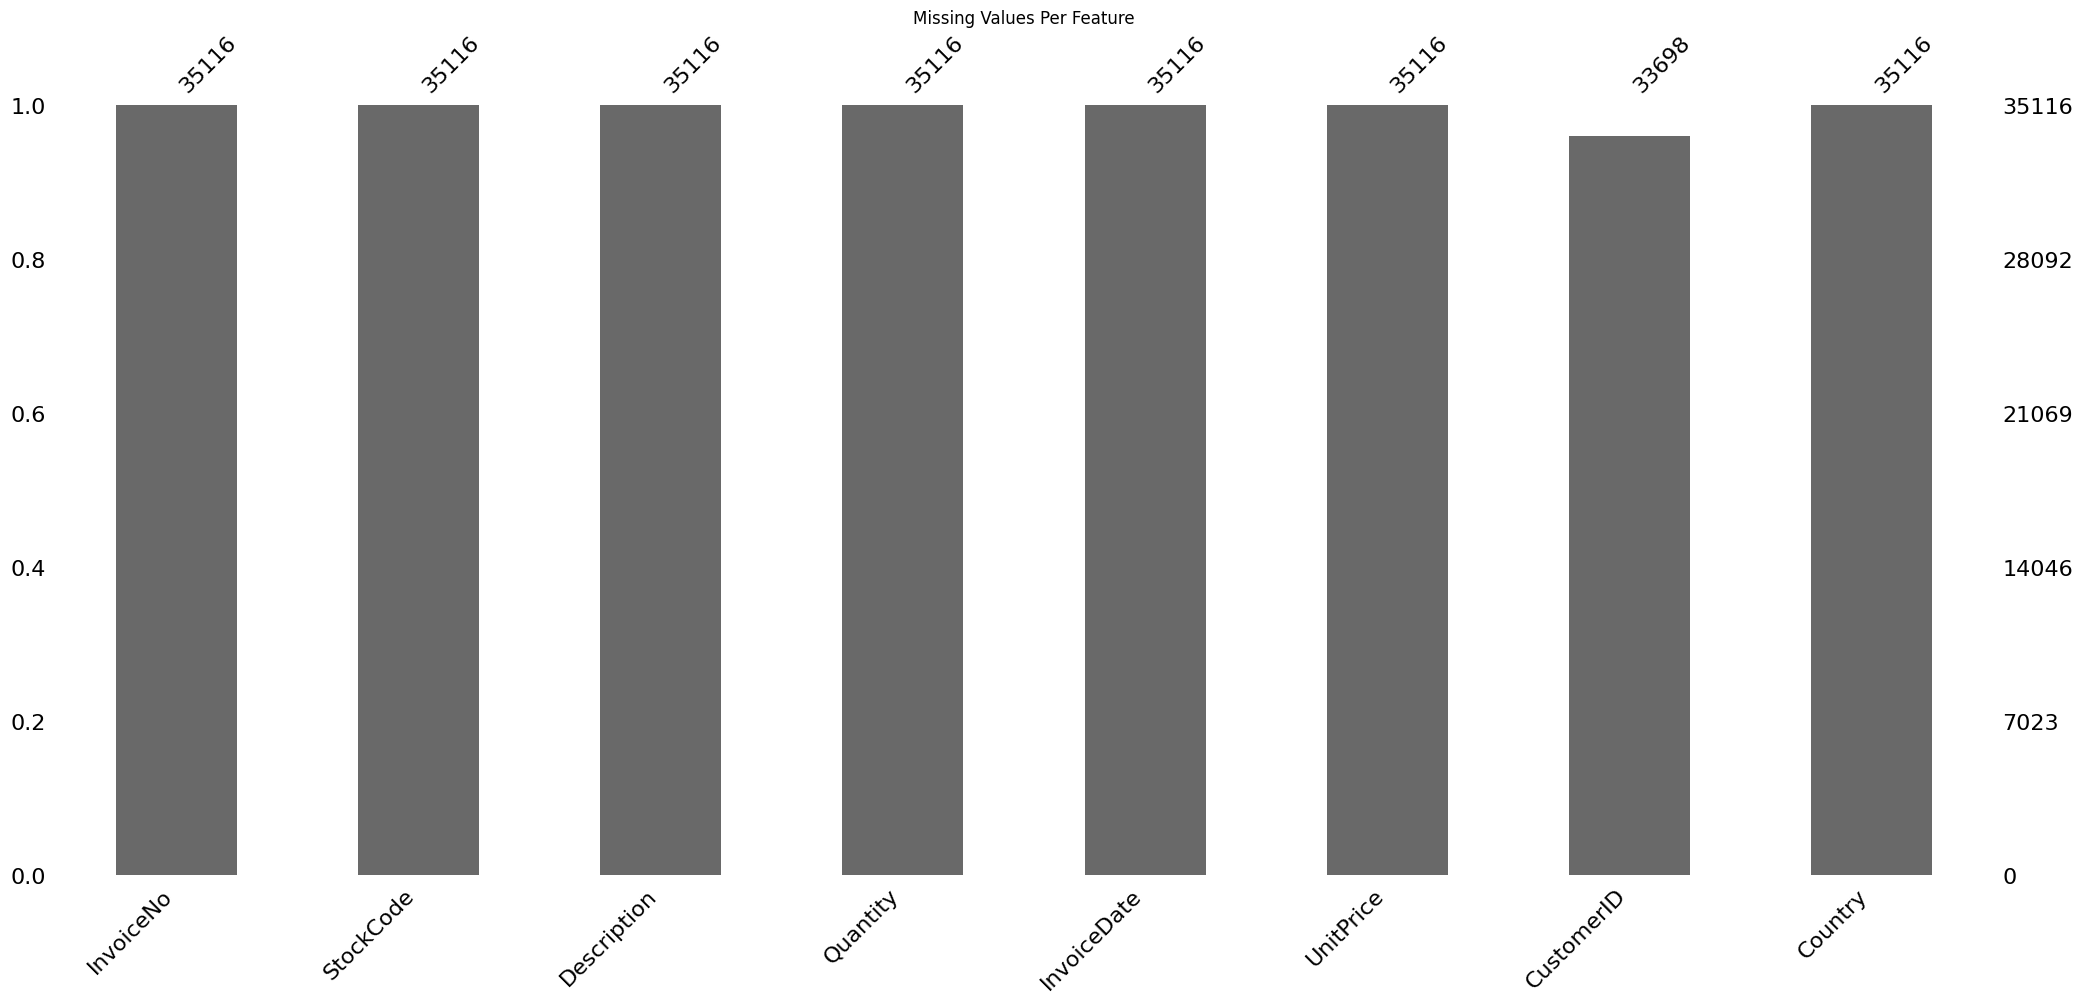

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

In [6]:
# Visualizing missing values
plt.figure(figsize=(10,6))
msno.bar(df)
plt.title("Missing Values Per Feature")
plt.show()

# Count missing values per column
df.isnull().sum()

we notice that there are 1418 rows where customer ID is missing, not knowing customerID of a buyer can leave critical comparisons imbalanced, due to which we have decided to drop the rows with no customerID.

In [7]:
# Drop rows where CustomerID is missing
df = df[df.CustomerID.notnull()]

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)

## 3.4 Processing Date and Time features
Why process date and time features?<br><br>
Processing date and time features is crucial for understanding temporal patterns, trends, and seasonality in data. Extracting elements like Year, Month, and Day of the Week from InvoiceDate allows us to analyze how sales and customer behavior change over time.

1. Extracting Year helps in analyzing year-over-year trends (e.g., comparing sales performance across different years).
2. Extracting Month allows us to detect seasonal patterns (e.g., higher sales in December due to holiday shopping).
3. Extracting Day of the Week helps in identifying which days are most profitable or least active (e.g., are weekends better for sales?).

In [10]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Extract Year, Month, and Day of Week
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,DayOfWeek
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2022-12-01 08:45:00,3.75,12583,France,2022.0,12.0,3.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2022-12-01 08:45:00,3.75,12583,France,2022.0,12.0,3.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2022-12-01 08:45:00,3.75,12583,France,2022.0,12.0,3.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2022-12-01 08:45:00,0.85,12583,France,2022.0,12.0,3.0
4,536370,21883,STARS GIFT TAPE,24,2022-12-01 08:45:00,0.65,12583,France,2022.0,12.0,3.0


Now we will feature engineer and create a Sales feature to see how many sales happen in a specific duration

In [25]:
# Create 'Sales' feature
df['Sales'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,DayOfWeek,Sales
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2022-12-01 08:45:00,3.75,12583,France,2022.0,12.0,3.0,90.0
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2022-12-01 08:45:00,3.75,12583,France,2022.0,12.0,3.0,90.0
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2022-12-01 08:45:00,3.75,12583,France,2022.0,12.0,3.0,45.0
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2022-12-01 08:45:00,0.85,12583,France,2022.0,12.0,3.0,10.2
4,536370,21883,STARS GIFT TAPE,24,2022-12-01 08:45:00,0.65,12583,France,2022.0,12.0,3.0,15.6


In [27]:
# Save cleaned transaction-level data
df.to_csv('C:/Users/satvi/OneDrive/Desktop/Customer_segmentation_project2/cleaned_transactions.csv', index=None)

#### Sales trend by year

<Axes: title={'center': 'Yearly Sales Trend'}, xlabel='Year'>

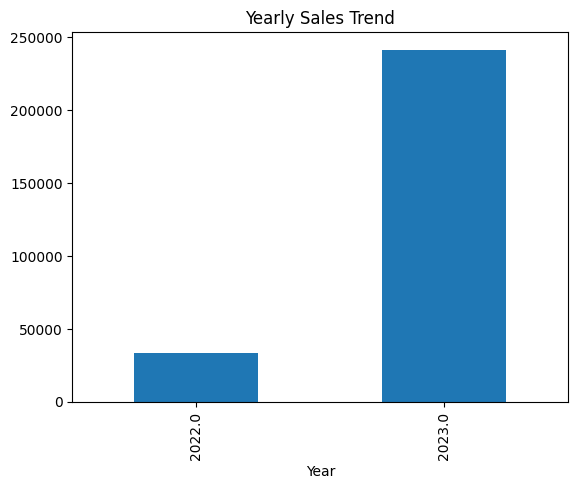

In [28]:
df.groupby('Year')['Sales'].sum().plot(kind='bar', title="Yearly Sales Trend")

#### Sales trend by month

<Axes: title={'center': 'Monthly Sales Trend'}, xlabel='Month'>

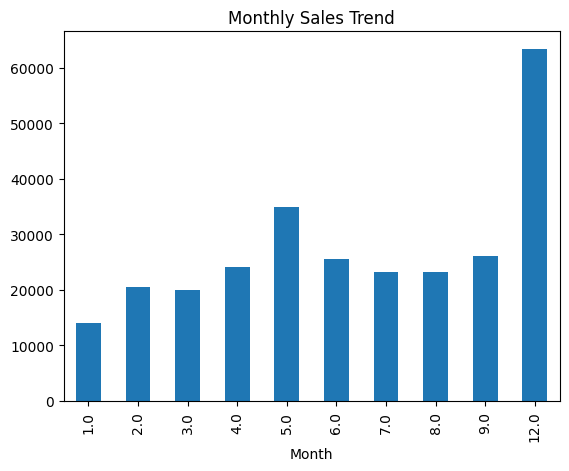

In [29]:
df.groupby('Month')['Sales'].sum().plot(kind='bar', title="Monthly Sales Trend")


#### Sales by days of the week

<Axes: title={'center': 'Sales by Day of the Week'}, xlabel='DayOfWeek'>

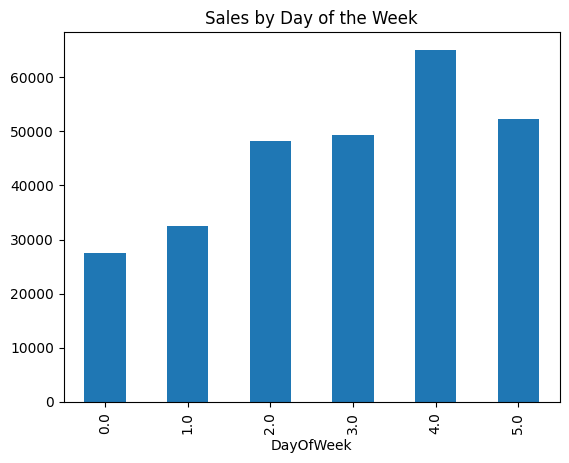

In [30]:
df.groupby('DayOfWeek')['Sales'].sum().plot(kind='bar', title="Sales by Day of the Week")


## 3.5 Analysing numerical features

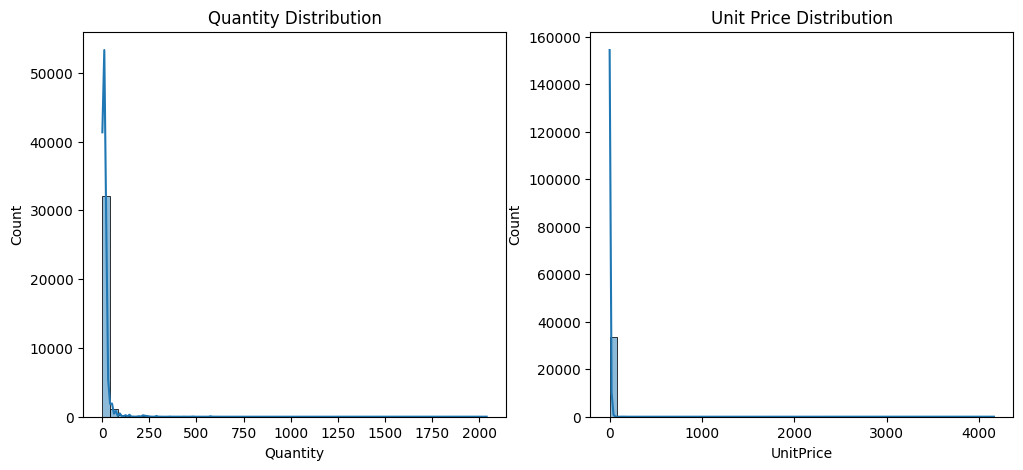

In [31]:
# Histograms for Quantity and UnitPrice
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['Quantity'], bins=50, kde=True, ax=axes[0])
axes[0].set_title('Quantity Distribution')

sns.histplot(df['UnitPrice'], bins=50, kde=True, ax=axes[1])
axes[1].set_title('Unit Price Distribution')

plt.show()

The two histograms shown in the image represent the distribution of Quantity and UnitPrice in the dataset.<br>
1. Left histogram: Quantity distribution<br>
Most transactions involve small quantities, clustered close to 0-50.<br>
A few orders have very large quantities (e.g., > 500), but they are rare.<br><br>

2. Right Histogram: Unit Price Distribution<br>
Most prices are close to 0-50, meaning the majority of items are inexpensive.<br>
A small number of items have extremely high prices (e.g., >1000).

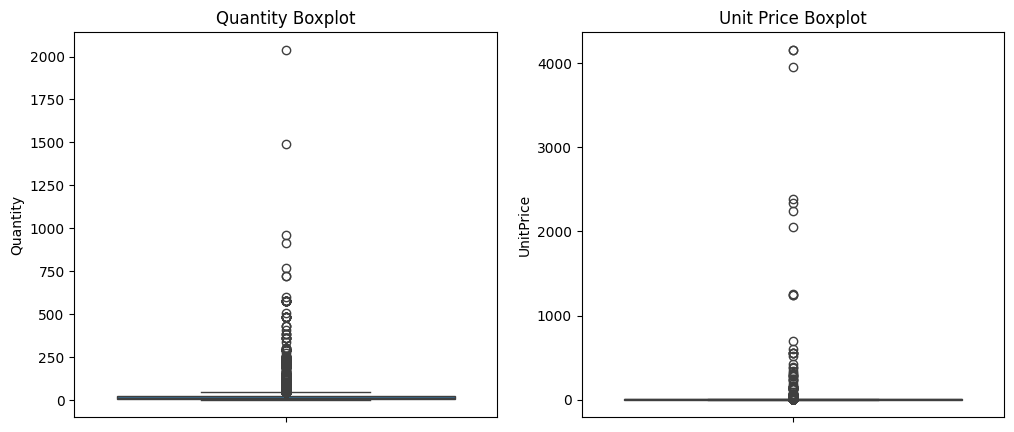

In [32]:
# Boxplots for Quantity and UnitPrice
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(y=df['Quantity'], ax=axes[0])
axes[0].set_title('Quantity Boxplot')

sns.boxplot(y=df['UnitPrice'], ax=axes[1])
axes[1].set_title('Unit Price Boxplot')

plt.show()

1. Left Boxplot: Quantity<br>
Most values are clustered near the bottom, meaning the majority of transactions involve small quantities.<br>
2. Right Boxplot: Unit Price<br>
Most products have low unit prices, as seen by the box being close to the bottom.

# 3.6 Customer-level feature engineering
Now that we have a cleaned transaction-level dataset, it's time to **roll it up** (aggregate up) to the customer level, which we'll feed into our machine learning algorithms later.

We want 1 customer per row, and we want the features to represent information such as:
* Number of unique purchases by the customer
* Average cart value for the customer
* Total sales for the customer
* Etc.

To do so, we'll use two tools seen already:
* groupby() to roll up by customer.
* agg() to engineer aggregated features.

Aggegrate invoice data by customer. We'll engineer 1 feature:
* 'total_transactions' - the total number of unique transactions for each customer.

In [21]:
invoice_data = df.groupby('CustomerID').agg(total_transactions=('InvoiceNo', 'nunique'))
invoice_data.head()


,total_transactions
CustomerID,
12347,7
12348,4
12349,1
12350,1
12352,8


In [23]:
# Aggregate product data
product_data = df.groupby('CustomerID').agg(
    total_products=('StockCode', 'count'),
    total_unique_products=('StockCode', 'nunique')
)

product_data.head()

,total_products,total_unique_products
CustomerID,,
12347,182,102
12348,31,22
12349,73,73
12350,17,17
12352,85,59


By definition, 'total_unique_products' should always be less than or equal to 'total_products'.

Finally, aggregate sales data by customer. Engineer 2 features:
* 'total_sales' - the total sales for each customer.
* 'avg_product_value' - the average value of the products purchased by the customer (not the UnitPrice!).

In [33]:
# Roll up sales data
sales_data = df.groupby('CustomerID').agg(
    total_sales=('Sales', 'sum'),
    avg_product_value=('Sales', 'mean')
)

sales_data.head()


,total_sales,avg_product_value
CustomerID,,
12347,4425.80,24.317582
12348,1797.24,57.975484
12349,1804.95,24.725342
12350,344.60,20.270588
12352,2521.04,29.659294


# 3.7 Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.
* 'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).

Therefore, let's first aggregate cart data at the "cart-level."
* We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [35]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID', 'InvoiceNo']).agg(
    cart_value=('Sales', 'sum')
)

# Display cart data for first 20 carts
cart_data.head(20)


cart_value
CustomerID InvoiceNo            
12347      537626         711.79
           542237         530.59
           549222         636.25
           556201         382.52
           562032         610.11
           573523        1319.52
           582380         235.02
12348      539318         892.80
           541998         227.44
           548955         367.00
           568172         310.00
12349      577609        1804.95
12350      543037         344.60
12352      544156         296.50
           545323         144.35
           545332         840.30
           546869         120.33
           547390         160.33
           567505         381.25
           568699         266.25

In [36]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347,537626,711.79
1,12347,542237,530.59
2,12347,549222,636.25
3,12347,556201,382.52
4,12347,562032,610.11
5,12347,573523,1319.52
6,12347,582380,235.02
7,12348,539318,892.80
8,12348,541998,227.44
9,12348,548955,367.00


Now that we have cart-level cart data, all we need to do is roll up by CustomerID again to get customer-level cart data.

Aggregate cart data by customer. Engineer 3 features:
* 'avg_cart_value' - average cart value by customer.
* 'min_cart_value' - minimum cart value by customer.
* 'max_cart_value' - maximum cart value by customer.

In [38]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').agg(
    avg_cart_value=('cart_value', 'mean'),
    min_cart_value=('cart_value', 'min'),
    max_cart_value=('cart_value', 'max')
)

# Display cart data for the first 5 customers
agg_cart_data.head()


,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347,632.257143,235.02,1319.52
12348,449.310000,227.44,892.80
12349,1804.950000,1804.95,1804.95
12350,344.600000,344.60,344.60
12352,315.130000,120.33,840.30


# 3.8 Joining various customer level dataframes
We have multiple dataframes that each contain customer-level features:
* invoice_data
* product_data
* sales_data
* agg_cart_data

Let's join the various customer-level datasets together with the .join() function.
* Just pick one of the customer-level dataframes and join it to a list of the others.
* By default, it will join the dataframes on their index... In this case, it will join by CustomerID, which is exactly what we want.
* You can read more about the .join() function in the official documentation.

In [39]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347,7,182,102,4425.80,24.317582,632.257143,235.02,1319.52
12348,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349,1,73,73,1804.95,24.725342,1804.950000,1804.95,1804.95
12350,1,17,17,344.60,20.270588,344.600000,344.60,344.60
12352,8,85,59,2521.04,29.659294,315.130000,120.33,840.30


Finally, let's save customer_df as our **analytical base table** to use later.


In [41]:
# Save analytical base table
customer_df.to_csv('C:/Users/satvi/OneDrive/Desktop/Customer_segmentation_project2/analytical_base_table.csv')